In [ ]:
#!pip install scikit-optimize

In [6]:
# Imports
# standard libraries
import pandas as pd
import numpy as np
import pickle 
# model
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    make_scorer, 
    fbeta_score
)

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# parameter optimization
from skopt import BayesSearchCV

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# src imports
# import sys
# sys.path.append('../src')

# from data.load_data import load_data
# from models.evaluate_model import calibrate_predictions, get_model_metrics,  plot_model_evaluation

### 1. Load Data from Pickle Files

In [7]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads a DataFrame from a pickle file.

    Parameters:
    - file_path (str): The path to the pickle file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

In [8]:
X_train = load_data('../data/processed/X_train.pkl')
y_train = load_data('../data/processed/y_train.pkl')

X_test = load_data('../data/processed/X_test.pkl')
y_test = load_data('../data/processed/y_test.pkl')

In [9]:
# Verify size
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9000, 16), y_train shape: (9000,)
X_test shape: (1000, 16), y_test shape: (1000,)


In [10]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,CardType,PointEarned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7185,777,44,3,124655.59,2,0,1,79792.30,4,1,372,False,True,False,False,True
6898,575,41,2,100062.39,1,0,0,126307.25,1,1,599,False,False,True,False,True
5808,684,60,2,116563.58,1,1,0,120257.70,1,0,969,True,False,False,False,True
584,647,51,1,119741.77,2,0,0,54954.51,3,0,847,False,True,False,True,False
6860,727,45,6,114422.85,2,1,1,104678.78,5,2,346,False,True,False,False,True


In [11]:
y_train.head()

7185    0
6898    0
5808    1
584     1
6860    1
Name: Exited, dtype: int64

### 2. Model Selection

In [12]:
# Setting up the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

### 3. Model Training

In [14]:
random_forest_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 4. Model Evaluation

In [15]:
y_test_pred = random_forest_model.predict(X_test)

In [16]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> None:
    """
    Calculate and print model performance metrics: Accuracy, F1-Score, Precision, Recall, F2-Score,
    and display the Confusion Matrix and Classification Report.

    Parameters:
    - y_true (np.ndarray): True labels of the validation dataset.
    - y_pred (np.ndarray): Predicted labels from the model.
    - model_name (str): Name of the model being evaluated.

    Returns:
    - None: This function prints the evaluation metrics, confusion matrix, and classification report.
    """
    # Precision and Recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    
    # F2 Score
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
        
    print(f"Evaluation for {model_name}:")
    print(f"F1-Score: {f1:.2f}")
    print(f"F2-Score: {f2:.2f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Evaluation for Random Forest with Calibration:
F1-Score: 0.59
F2-Score: 0.52

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       796
           1       0.78      0.48      0.59       204

    accuracy                           0.87      1000
   macro avg       0.83      0.72      0.76      1000
weighted avg       0.86      0.87      0.85      1000



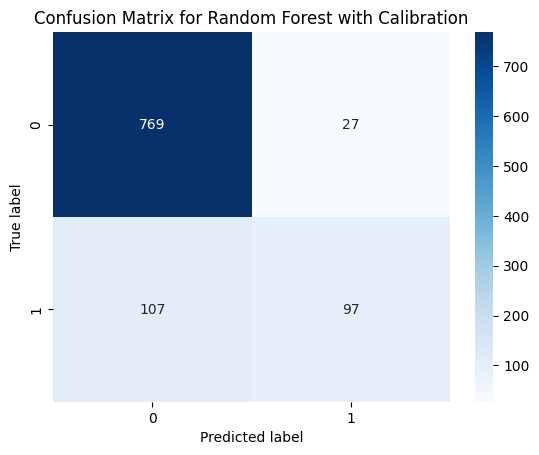

In [17]:
evaluate_model(y_test, y_test_pred, "Random Forest with Calibration")

### 5. Hyperparameter Optimization

In [18]:
# Define a custom scorer for F2-Score to prioritize churners
def f2_score_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

custom_scorer = make_scorer(f2_score_scorer, greater_is_better=True)

In [19]:
# Parameter space
param_space = {
    'n_estimators': (50, 300),  # Number of trees in the forest
    'max_depth': (5, 50),       # Maximum depth of the trees
    'min_samples_split': (2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 10),   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for splitting
    'class_weight': ['balanced', 'balanced_subsample']  # Supported options
}

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Set up Bayesian Optimization with BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=random_forest_model,
    search_spaces=param_space,
    n_iter=30,  # Number of optimization iterations
    scoring=custom_scorer,
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1
)

# Perform Bayesian optimization
print("Starting Bayesian Optimization...")
bayes_search.fit(X_train, y_train)

# Best parameters from the search
print("Best Parameters:", bayes_search.best_params_)

Starting Bayesian Optimization...
Best Parameters: OrderedDict([('class_weight', 'balanced'), ('max_depth', 7), ('max_features', None), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 122)])


Evaluation for Optimized Random Forest:
F1-Score: 0.61
F2-Score: 0.69

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.86       796
           1       0.50      0.76      0.61       204

    accuracy                           0.80      1000
   macro avg       0.72      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000



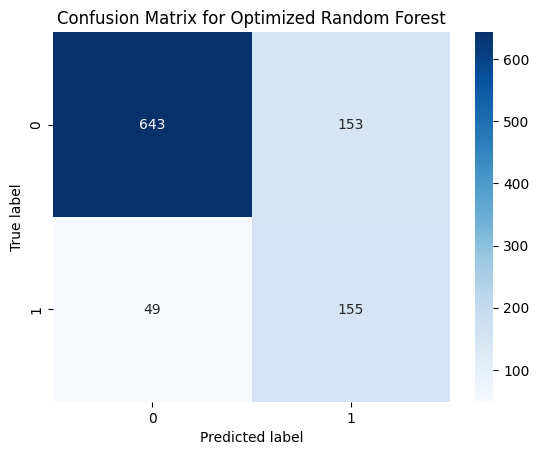

In [20]:
# Evaluate the optimized model on the test set
best_model = bayes_search.best_estimator_
y_test_pred = best_model.predict(X_test)
evaluate_model(y_test, y_test_pred, "Optimized Random Forest")